In [11]:
import pandas as pd
import numpy as np

### Warnings
import warnings

### Text Preprocessing and Natural Language Processing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import nltk
import re
import spacy
from wordcloud import WordCloud

# For parallel processing
import multiprocessing

import torch.nn as nn
import torch
import torch.nn.functional as F

Data load - generic data input first

Load: data_iter1.csv
- subject to changes

In [12]:
df = pd.read_csv("data_iter1.csv")

C:\Users\Wade\AppData\Local\Temp\ipykernel_12524\633485919.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data_iter1.csv")


In [13]:
df.head(2)

,UserID,MovieID,Rating,Timestamp,Title,Genres,Gender,Age,Occupation,ZipCode,...,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,year,title_year
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,48067,...,A petty criminal fakes insanity to serve his s...,36.673,/3jcbDmRFiQ83drXNOvRDeKHxS0C.jpg,"If he's crazy, what does that make you?",Drama,Fantasy Films,United States of America,English,1975.0,One Flew Over the Cuckoo's Nest (1975)
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical,F,1,10,48067,...,When the young orphan boy James spills a magic...,27.497,/nl2oB6EbD1fHFuP2TLUHDtqs7Ux.jpg,Adventures this big don't grow on trees.,"Adventure, Animation, Family, Fantasy","Allied Filmmakers, Walt Disney Pictures",United States of America,English,1996.0,James and the Giant Peach (1996)


In [14]:
movieID_title_dict = dict(zip( df['MovieID'], df['Title']))

# Sort the dictionary based on MovieID
sorted_dict = {k: movieID_title_dict[k] for k in sorted(movieID_title_dict)}

# Display the sorted dictionary
print(sorted_dict)

{1: 'Toy Story (1995)', 2: 'Jumanji (1995)', 3: 'Grumpier Old Men (1995)', 4: 'Waiting to Exhale (1995)', 5: 'Father of the Bride Part II (1995)', 6: 'Heat (1995)', 7: 'Sabrina (1995)', 8: 'Tom and Huck (1995)', 10: 'GoldenEye (1995)', 11: 'The American President (1995)', 12: 'Dracula: Dead and Loving It (1995)', 13: 'Balto (1995)', 14: 'Nixon (1995)', 15: 'Cutthroat Island (1995)', 16: 'Casino (1995)', 17: 'Sense and Sensibility (1995)', 18: 'Four Rooms (1995)', 19: 'Ace Ventura: When Nature Calls (1995)', 20: 'Money Train (1995)', 21: 'Get Shorty (1995)', 22: 'Copycat (1995)', 23: 'Assassins (1995)', 24: 'Powder (1995)', 25: 'Leaving Las Vegas (1995)', 26: 'Othello (1995)', 27: 'Now and Then (1995)', 28: 'Persuasion (1995)', 29: 'The City of Lost Children (1995)', 30: 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)', 31: 'Dangerous Minds (1995)', 32: 'Twelve Monkeys (1995)', 33: 'Wings of Courage (1995)', 34: 'Babe (1995)', 35: 'Carrington (1995)', 36: 'Dead Man Walking (1995)'

In [15]:
user_movie_counts = df.groupby('UserID')['MovieID'].count()
print(len(user_movie_counts))
user_movie_counts.describe() # 6040 users, each user has indicated ratings for range(19, 2300) movies

6040


count    6040.000000
mean      164.642219
std       191.632506
min        19.000000
25%        44.000000
50%        95.000000
75%       206.000000
max      2300.000000
Name: MovieID, dtype: float64

Part A) Collaborative Matrix

Obtaining user-item matrix

In [16]:
user_item_matrix = pd.pivot_table(df, values='Rating', index='UserID', columns='MovieID', fill_value=0)

print(f'Check Rows: {len(user_item_matrix)}, Check transformation: {len(user_item_matrix) == len(user_movie_counts)}')
user_item_matrix.head(2)

Check Rows: 6040, Check transformation: True


MovieID,1,2,3,4,5,6,7,8,10,11,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
user_ratings_count = df.groupby('UserID').size()

# Step 2: Find the user with the least number of ratings
user_with_least_ratings = user_ratings_count.idxmin()

# Step 3: Get the ratings of that user for each movie along with the corresponding MovieID
least_ratings_user_data = df[df['UserID'] == user_with_least_ratings][['UserID','MovieID', 'Rating']]

# Displaying the user with the least ratings, number of items rated, ratings for each movie, and corresponding MovieID
print("UserID with least ratings:", user_with_least_ratings)
print("Number of items rated:", len(least_ratings_user_data))
print("Ratings for each movie:")
least_ratings_user_data.sort_values("MovieID")

UserID with least ratings: 160
Number of items rated: 19
Ratings for each movie:


,UserID,MovieID,Rating
21714,160,260,4
21718,160,480,4
21702,160,648,2
21720,160,1097,3
21717,160,1210,3
21705,160,1282,4
21706,160,1286,5
21708,160,1387,3
21709,160,1396,4
21710,160,1544,3


Part B) Neural Collaborative Filtering 

https://www.youtube.com/watch?v=O4lk9Lw7lS0

https://gist.github.com/khuangaf/bf2a216019d29a4a1014f71dbfff51d0

In [18]:
user_item_matrix_binary = np.where(user_item_matrix != 0, 1, 0)

# Convert the result back to DataFrame if needed
user_item_matrix_binary_df = pd.DataFrame(user_item_matrix_binary, index=user_item_matrix.index, columns=user_item_matrix.columns)
# show for user 19
user_160_data = user_item_matrix_binary_df.loc[160][user_item_matrix_binary_df.loc[160] != 0]
print(user_160_data)


MovieID
260     1
480     1
648     1
1097    1
1210    1
1282    1
1286    1
1387    1
1396    1
1544    1
2160    1
2791    1
2858    1
3185    1
3408    1
3510    1
3793    1
3798    1
3916    1
Name: 160, dtype: int32


Binary Ratings (Implicit Feedback):

Binary ratings represent whether a user interacted with an item or not.
Example: If a user viewed or purchased an item, the rating is 1; otherwise, it's 0.

In [19]:
print(f"Shape Row X Column: {user_item_matrix_binary_df.shape}") 
# these are implicit ratings
user_item_matrix_binary_df.head(2)

Shape Row X Column: (6040, 3672)


MovieID,1,2,3,4,5,6,7,8,10,11,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


https://image.slidesharecdn.com/ncf-180902121818/75/neural-collaborative-filtering-explanation-implementation-23-2048.jpg?cb=1668038901
<img src="https://image.slidesharecdn.com/ncf-180902121818/75/neural-collaborative-filtering-explanation-implementation-23-2048.jpg?cb=1668038901" alt="Model Archi" style="width:50%;">

Combination of Generalised Matrix Factorisation and MultiLayer Perceptron (NN)

In [17]:
class NeuMF(nn.Module):
    def __init__(self, config):
        super(NeuMF, self).__init__()

        #mf part
        self.embedding_user_mf = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim_mf)
        self.embedding_item_mf = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim_mf)
        
        #mlp part
        self.embedding_user_mlp = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim_mlp)
        self.embedding_item_mlp = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim_mlp)
        
        self.fc_layers = nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(config['layers'][:-1], config['layers'][1:])):
            self.fc_layers.append(nn.Linear(in_size, out_size))

        self.logits = nn.Linear(in_features=config['layers'][-1] + config['latent_dim_mf']  , out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, user_indices, item_indices, titles):
        user_embedding_mlp = self.embedding_user_mlp(user_indices)
        item_embedding_mlp = self.embedding_item_mlp(item_indices)
        user_embedding_mf = self.embedding_user_mf(user_indices)
        item_embedding_mf = self.embedding_item_mf(item_indices)

        #### mf part
        mf_vector = torch.mul(user_embedding_mf, item_embedding_mf)
        mf_vector = nn.Dropout(self.config.dropout_rate_mf)(mf_vector)

        #### mlp part        
        mlp_vector = torch.cat([user_embedding_mlp, item_embedding_mlp], dim=-1)  # the concat latent vector
        
        for idx, _ in enumerate(range(len(self.fc_layers))):
            mlp_vector = self.fc_layers[idx](mlp_vector)
            mlp_vector = nn.ReLU()(mlp_vector)
        mlp_vector = nn.Dropout(self.config.dropout_rate_mlp)(mlp_vector)

        vector = torch.cat([mlp_vector, mf_vector], dim=-1)
        logits = self.logits(vector)
        output = self.sigmoid(logits)
        return output

In [68]:
device = torch.device('cpu')
print(device.type)

cpu


In [89]:
from torch.utils.data import TensorDataset
user_indices = torch.tensor(user_item_matrix_binary_df.index.values, dtype=torch.int64)

# Get the item indices
item_indices = torch.tensor(user_item_matrix_binary_df.columns.values, dtype=torch.int64)

# Convert DataFrame to numpy array and then to PyTorch tensor
user_item_matrix_array = user_item_matrix_binary_df.values
user_item_matrix_tensor = torch.tensor(user_item_matrix_array, dtype=torch.float32)

# Create a TensorDataset
#dataset = TensorDataset(user_indices, item_indices, user_item_matrix_tensor)
user_item_matrix_tensor.shape


torch.Size([6040, 3672])

In [90]:
dataset = TensorDataset(user_indices, item_indices, user_item_matrix_tensor)

AssertionError: Size mismatch between tensors

In [70]:
import torch.optim as optim

# Prepared your input data as tensors: user_indices, item_indices, ratings
# Ratings data use implicit binary user item matrix

# Convert your data to DataLoader
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define your model
model = NeuMF()

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Training loop
for epoch in range(15):
    model.train()
    running_loss = 0.0
    
    for user_batch, item_batch, rating_batch in data_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(user_batch, item_batch)
        
        # Calculate loss
        loss = criterion(outputs, rating_batch)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * user_batch.size(0)
    
    epoch_loss = running_loss / len(dataset)
    print(f'Epoch [{epoch+1}/{10}], Loss: {epoch_loss:.4f}')

print('Training finished!')


TypeError: 'int' object is not callable

Part C) User item interactions only - General Collaborative filtering using GMF

In [70]:
print(user_item_matrix_binary_df.shape)
user_item_matrix_binary_df.head(2)

(6040, 3672)


MovieID,1,2,3,4,5,6,7,8,10,11,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
use_df = df[['UserID', 'MovieID', 'Rating']]
use_df.head(2)

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3


In [72]:
use_df.shape

(994439, 3)

In [73]:

class GeneralisedMF(nn.Module):
    def __init__(self, num_users, num_items, emb_size=64):
        super(GeneralisedMF, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.item_emb = nn.Embedding(num_items, emb_size)
        # init weights
        self.user_emb.weight.data.uniform_(0, 0.05)
        self.item_emb.weight.data.uniform_(0, 0.05)

    def forward(self, user, item):
        u = self.user_emb(user)
        v = self.item_emb(item)
        return (u*v).sum(1)

In [74]:
num_users = len(use_df.UserID.unique())
print(f'users: {num_users}')
num_items = len(use_df.MovieID.unique())
print(f'items: {num_items}')

users: 6040
items: 3672


In [75]:
print(use_df.UserID.values) 
print(f'index is the users, total of {len(use_df.UserID.values)}')

print(use_df.MovieID.values) 
print(f'total movies of {len(use_df.UserID.values)}')

[   1    1    1 ... 6040 6040 6040]
index is the users, total of 994439
[1193  661  914 ...  562 1096 1097]
total movies of 994439


In [160]:
def train(model, epoch=15, lr = 0.05, wd= 0.0 ):
    optimizer =  torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    # weight decay is penalty like regularisation param
    for i in range(epoch):
        model.train()
        users = torch.LongTensor(use_df.UserID.values)
        items = torch.LongTensor(use_df.MovieID.values)
        ratings = torch.FloatTensor(use_df.Rating.values)
        
        y_hat = model(users, items)
        loss = F.mse_loss(y_hat, ratings)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        print(f'Epoch {i}: train loss: {loss.item()}')


In [161]:
# run from here
model = GeneralisedMF(6042, 3960, 64)
## problem must change the data
# also, issue is total unique is 3672 but the movie id goes up 3952 thats why we have a problem
# looking up values in the embedding matrix

In [162]:
losses = []
train(model, epoch=100, lr = 0.25, wd= 1e-5)

Epoch 0: train loss: 13.7855806350708
Epoch 1: train loss: 2.8275177478790283
Epoch 2: train loss: 5.7764434814453125
Epoch 3: train loss: 4.023670196533203
Epoch 4: train loss: 3.911907196044922
Epoch 5: train loss: 1.7125860452651978
Epoch 6: train loss: 2.4654266834259033
Epoch 7: train loss: 3.302410364151001
Epoch 8: train loss: 2.3483002185821533
Epoch 9: train loss: 1.3269709348678589
Epoch 10: train loss: 2.1242873668670654
Epoch 11: train loss: 1.7085859775543213
Epoch 12: train loss: 1.3665448427200317
Epoch 13: train loss: 1.7469137907028198
Epoch 14: train loss: 1.6798876523971558
Epoch 15: train loss: 1.3698824644088745
Epoch 16: train loss: 1.3002289533615112
Epoch 17: train loss: 1.228192925453186
Epoch 18: train loss: 1.187441349029541
Epoch 19: train loss: 1.219288945198059
Epoch 20: train loss: 1.1702369451522827
Epoch 21: train loss: 1.146008849143982
Epoch 22: train loss: 1.100844144821167
Epoch 23: train loss: 0.9895960688591003
Epoch 24: train loss: 1.027088880538

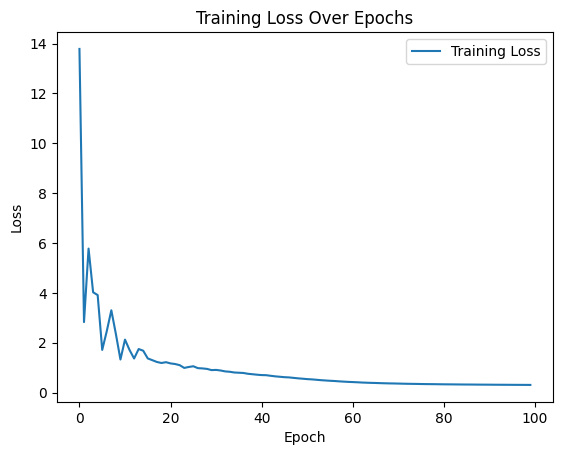

In [163]:
import matplotlib.pyplot as plt
plt.plot(range(len(losses)), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

need a validation loss to check where it curves out to
infinite training will over fit

In [175]:
users = torch.LongTensor(user_item_matrix_binary_df.index.values)
u = model.user_emb(users)

items = torch.LongTensor(user_item_matrix_binary_df.columns.values)
v = model.item_emb(items)

print(u.shape)
print(v.T.shape)
product_matrix = torch.matmul(u, v.T)
print(product_matrix)

torch.Size([6040, 64])
torch.Size([64, 3672])
tensor([[4.7405, 2.8466, 2.8638,  ..., 3.6690, 3.4630, 3.4378],
        [4.1788, 3.8683, 3.7631,  ..., 3.3296, 3.2387, 2.6024],
        [3.6986, 3.0951, 2.4832,  ..., 3.2769, 2.7600, 4.0614],
        ...,
        [3.7855, 2.8415, 2.3315,  ..., 2.9832, 2.8873, 3.8371],
        [3.7688, 3.2512, 3.5401,  ..., 3.4132, 3.4542, 4.0303],
        [3.3151, 1.4704, 1.7745,  ..., 2.7762, 3.5764, 4.1240]],
       grad_fn=<MmBackward0>)
